In [1]:
import torch
from utils.app_config import BaseAppConfig
from db_connectors.postgres_connection import BasePostgreSQLConnectionHandler
from retrievers.base_retriever import BaseDocumentRetriever

from readers.reader_factory import ChatModelFactory
from evaluation.retrieval_evaluation import evaluate_retriever_from_evaldata

## Exploration utility to see the distribution of the Hard Negatives mined Compared to Positives

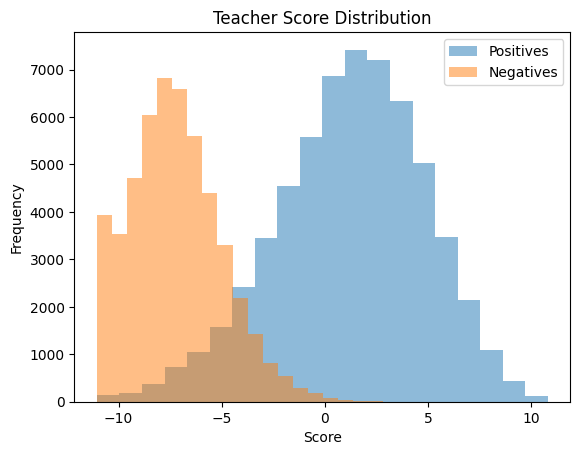

In [15]:
all_pos_scores = []
all_neg_scores = []

file_path = "data/train/input_train_data_minedHN_scored.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        example = json.loads(line)
        all_pos_scores.extend(example["pos_scores"])
        all_neg_scores.extend(example["neg_scores"])

plt.hist(all_pos_scores, bins=20, alpha=0.5, label='Positives')
plt.hist(all_neg_scores, bins=20, alpha=0.5, label='Negatives')
plt.legend()
plt.title("Teacher Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

## Sample usage of classes based on a configuration set by a embedding model, a reranker optionally and a reader model.

In [28]:
config = BaseAppConfig()
embedding_config = config.embedder_config
reranker_config = config.reranker_config
reader_config = config.reader_config
evaluator_llm_name = config.evaluator_llm_name
evaluation_files_dir = config.evaluation_files_dir
corpus_table = config.corpus_table

In [31]:
embed_config = {'name': 'src_bge_base_en_v15_hnsw',
   'store_table': 'src_bge_base_en_v15_hnsw',
   'embedding_dim': 768,
   'model_config': {'device': 'cuda',
    'use_meta': False,
    'trust_remote_code': True,
    'use_fp16': True,
    'model_name_or_path': 'BAAI/bge-base-en-v1.5',
    'cache_dir': './models/cache/model',
    'model_class': 'encoder-only-base'},
   'text_splitter_config': {'chunk_size': 400,
    'chunk_overlap': 50,
    'separators': ['\n\n', '\n', '. ', ' ', '']},
   'index_config': {'name': 'hnsw',
    'm': 16,
    'ef_construction': 64,
    'ef_search': 40}}

In [35]:
rerank_config = {'name': 'bge_reranker_base',
   'model_name_or_path': './models/fine-tuned/bge_reranker_base/checkpoint-1000',
   'cache_dir': './models/cache/model',
   'model_class': 'encoder-only-base',
   'use_fp16': True,
   'trust_remote_code': True,
   'device': 'cuda',
   'batch_size': 16}

In [40]:
reader_config

{'OpenAI': [{'name': 'gpt-4o', 'model': 'gpt-4o', 'temperature': 0},
  {'name': 'gpt-3.5-turbo', 'model_name': 'gpt-3.5-turbo', 'temperature': 0}],
 'Anthropic': [{'name': 'claude-3-sonnet',
   'model': 'claude-3-5-sonnet-20240620',
   'temperature': 0}]}

In [37]:
indx_config = {'name': 'hnsw',
    'm': 16,
    'ef_construction': 64,
    'ef_search': 40}

In [47]:
db_con = BasePostgreSQLConnectionHandler(config.conn_config)


retriever =  BaseDocumentRetriever(
        db_con,
        corpus_table,
        embed_config.get("store_table"),
        embedding_config=embed_config.get("model_config"),
        reranker_config=rerank_config,
        store_index_config=indx_config
    )

`pooling_method` is not specified, use default pooling method 'cls'.
`query_instruction_format` is not specified, set to default value '{}{}'.


In [43]:
system_prompt ="""Answer this question based on the provided context
"""
provider = "OpenAI"
llm_config = {'name': 'gpt-4o', 'model': 'gpt-4o', 'temperature': 0}

reader = ChatModelFactory.get_model(system_prompt, provider, llm_config)

/home/victor/Projects/tfm/readers/openai_chat_reader.py:8: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  self.llm = ChatOpenAI(**(model_config_kargs or {}))


In [59]:
query = "Concizumab is used for which diseases?"

docs, _ = retriever.get_top_k_docs(query, 100) # unpack like this, always return the vector store latency when returning the similar records.

In [60]:
docs

[{'id': '37341887',
  'content': 'Concizumab: First Approval.',
  'chunk': 0,
  'score': 0.8674772055084603,
  'beginoffset': 0,
  'endoffset': 27},
 {'id': '31394258',
  'content': 'Concizumab is a humanized monoclonal antibody in clinical investigation directed against membrane-bound and soluble tissue factor pathway inhibitor (mTFPI and sTFPI) for treatment of hemophilia',
  'chunk': 1,
  'score': 0.8080936853736279,
  'beginoffset': 0,
  'endoffset': 193},
 {'id': '33570646',
  'content': 'Concizumab is a novel subcutaneous prophylactic therapy for hemophilia. It is a hemostatic rebalancing agent that binds to the Kunitz-2 domain of tissue factor pathway inhibitor (TFPI), one of the molecules that contributes to downregulation of coagulation thereby preventing TFPI from binding to and blocking the factor Xa (FXa) active site',
  'chunk': 1,
  'score': 0.8078865825465794,
  'beginoffset': 0,
  'endoffset': 341},
 {'id': '37646676',
  'content': 'Concizumab is an anti-tissue factor p

In [61]:
max_context_k = 5
reader.answer(query, docs[:max_context_k])

'Concizumab is used for the treatment of hemophilia.'

In [70]:
system_prompt ="""Answer this question based on the provided context
"""
provider = "Anthropic"
llm_config = {'name': 'claude-3-sonnet',
               'model': 'claude-3-5-sonnet-20240620',
               'temperature': 0}

reader = ChatModelFactory.get_model(system_prompt, provider, llm_config)

In [71]:
max_context_k = 5
reader.answer(query, docs[:max_context_k])

'Based on the provided context, concizumab is primarily used for the treatment of hemophilia. Specifically:\n\n1. It is being investigated as a treatment for hemophilia, including hemophilia A and B.\n\n2. It is described as a novel subcutaneous prophylactic therapy for hemophilia.\n\n3. It is designed to achieve hemostasis (control of bleeding) in all hemophilia types.\n\n4. It has been studied in patients with hemophilia A or B with inhibitors.\n\nThe context indicates that concizumab is particularly useful in cases of hemophilia where patients have developed inhibitors, which are antibodies that can interfere with standard factor replacement treatments. Concizumab works by targeting the tissue factor pathway inhibitor (TFPI), which helps to rebalance the coagulation system in people with hemophilia, regardless of the specific type of hemophilia they have.'

In [66]:
files = os.listdir(config.evaluation_files_dir)
files

['12B4_golden.json',
 '12B3_golden.json',
 '12B2_golden.json',
 '12B1_golden.json',
 'training12b_new.json']

In [68]:
path = os.path.join(config.evaluation_files_dir,'12B4_golden.json')


#evaluate_retriever_from_evaldata(retriever, '12B4_golden.json', (5,10,15, 50), top_k=100, rerank_top_k=50, use_rerank=True, overlap_threshold=0.5)